In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from keras.models import Sequential
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Input, Lambda
from tensorflow.keras.models import Model

In [3]:
from tensorflow.keras.applications import ResNet50

In [4]:
import splitfolders # or import splitfolders
input_folder = "data/classification"
output = "data/output" #where you want the split datasets saved. one will be created if it does not exist or none is set

splitfolders.ratio(input_folder, output=output, seed=42, ratio=(.6, .4)) # ratio of split are in order of train/val/test. You can change to whatever you want. For train/val sets only, you could do .75, .25 for example.

Copying files: 600 files [00:00, 2178.37 files/s]


In [5]:
train_path = "data/output/train"
test_path = "data/output/val"

In [6]:
# Resizinig all the images to (224,224)
IMAGE_SIZE = [128,128]

In [7]:
# Scaling all the images between 0 to 1

train_datagen = ImageDataGenerator(rescale = 1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=False)

# Performing only scaling on the test dataset

test_datagen = ImageDataGenerator(rescale=1./255)

In [8]:
train_set = train_datagen.flow_from_directory(train_path,
                                              target_size=(128,128),
                                              batch_size=2,
                                              class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(test_path,
                                            target_size=(128,128),
                                            batch_size=2,
                                            class_mode='categorical')

Found 360 images belonging to 3 classes.
Found 240 images belonging to 3 classes.


In [9]:
from keras.metrics import Precision, Recall
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential, Model

learning_rate_reduction = ReduceLROnPlateau(
    monitor="val_accuracy", patience=3, verbose=1, factor=0.3, min_lr=0.0000001
)
early_stop = EarlyStopping(
    patience=10,
    verbose=1,
    monitor="val_accuracy",
    mode="max",
    min_delta=0.001,
    restore_best_weights=True,
)

In [10]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [11]:
ML_Model = []
accuracy = []
precision = []
recall = []
f1score = []

#function to call for storing the results
def storeResults(model, a,b,c,d):
    ML_Model.append(model)
    accuracy.append(round(a, 3))
    precision.append(round(b, 3))
    recall.append(round(c, 3))
    f1score.append(round(d, 3))

# ResNet50

In [12]:
res101=ResNet50(input_shape = IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [13]:
x1= Flatten()(res101.output)
prediction1 = Dense(3, activation='softmax')(x1)
model1 = Model(inputs = res101.inputs, outputs = prediction1)
model1.summary()
model1.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=["accuracy",f1_m,precision_m, recall_m])

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [14]:
hist1 = model1.fit(train_set, validation_data=test_set, epochs=30, steps_per_epoch=len(train_set), validation_steps=len(test_set),callbacks=[learning_rate_reduction, early_stop])

Epoch 1/30
180/180 [==============================] - 17s 64ms/step - loss: 7.6881 - accuracy: 0.3944 - f1_m: 0.3306 - precision_m: 0.3639 - recall_m: 0.3139 - val_loss: 1.0975 - val_accuracy: 0.3208 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/30
180/180 [==============================] - 11s 59ms/step - loss: 3.3185 - accuracy: 0.3472 - f1_m: 0.2824 - precision_m: 0.3306 - recall_m: 0.2583 - val_loss: 1.2071 - val_accuracy: 0.3333 - val_f1_m: 0.2361 - val_precision_m: 0.2667 - val_recall_m: 0.2208
Epoch 3/30
180/180 [==============================] - 10s 57ms/step - loss: 1.3225 - accuracy: 0.4750 - f1_m: 0.4222 - precision_m: 0.4778 - recall_m: 0.3944 - val_loss: 1.5743 - val_accuracy: 0.3708 - val_f1_m: 0.3667 - val_precision_m: 0.3750 - val_recall_m: 0.3625
Epoch 4/30
180/180 [==============================] - 11s 59ms/step - loss: 1.1037 - accuracy: 0.5417 - f1_m: 0.4833 - precision_m: 0.5333 - recall_m: 0.4583 - val_loss: 1.5398 - val_a

In [15]:
dl_acc = hist1.history["val_accuracy"][29]
dl_prec = hist1.history["val_precision_m"][29]
dl_rec = hist1.history["val_recall_m"][29]
dl_f1 = hist1.history["val_f1_m"][29]

storeResults('ResNet50',dl_acc,dl_prec,dl_rec,dl_f1)

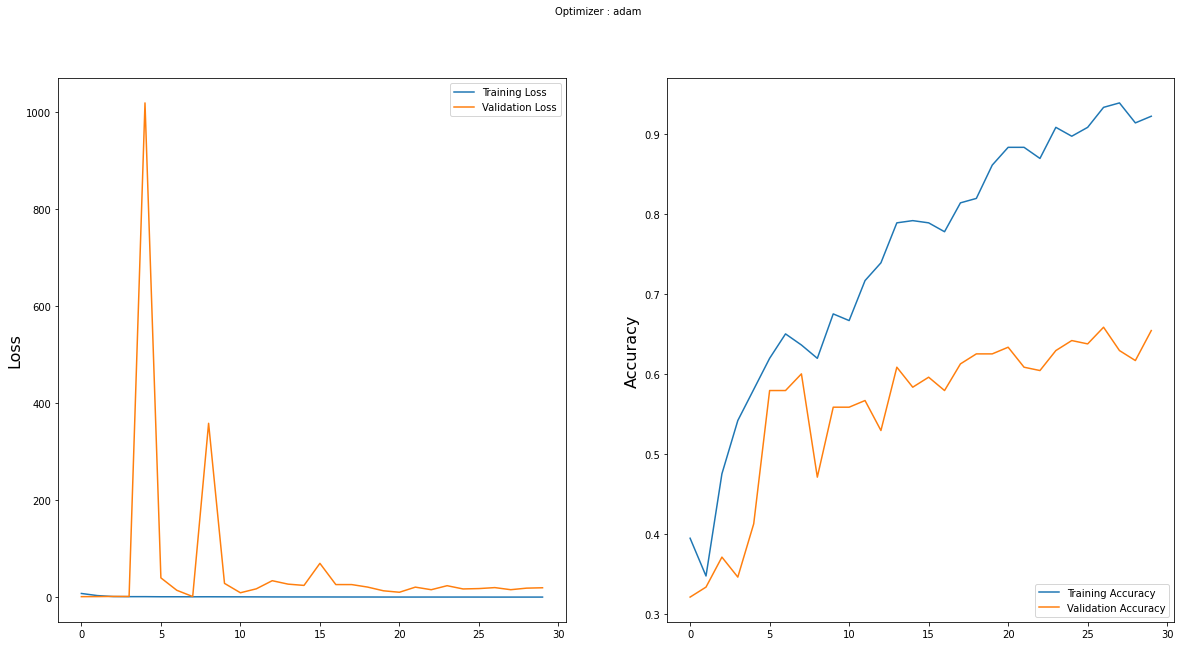

In [16]:
import matplotlib.pyplot as plt

x=hist1
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(x.history['loss'], label='Training Loss')
plt.plot(x.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(x.history['accuracy'], label='Training Accuracy')
plt.plot(x.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

# CNN

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, MaxPool2D, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [18]:
model4 = Sequential()
model4.add(Conv2D(filters=32, kernel_size=(5,5), padding='same', activation='relu', input_shape=(128, 128, 3)))
model4.add(MaxPool2D(strides=2))
model4.add(Conv2D(filters=48, kernel_size=(5,5), padding='valid', activation='relu'))
model4.add(MaxPool2D(strides=2))
model4.add(Flatten())
model4.add(Dense(256, activation='relu'))
model4.add(Dense(84, activation='relu'))
model4.add(Dense(3, activation='softmax'))

In [19]:
model4.summary()
model4.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=["accuracy",f1_m,precision_m, recall_m])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 60, 48)        38448     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 48)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 43200)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               11059456  
_________________________________________________________________
dense_2 (Dense)              (None, 84)                2

In [20]:
hist4 = model4.fit(train_set, validation_data=test_set, epochs=30, steps_per_epoch=len(train_set), validation_steps=len(test_set),callbacks=[learning_rate_reduction, early_stop])

Epoch 1/30
180/180 [==============================] - 8s 40ms/step - loss: 1.1130 - accuracy: 0.4028 - f1_m: 0.1046 - precision_m: 0.1417 - recall_m: 0.0861 - val_loss: 1.1170 - val_accuracy: 0.3375 - val_f1_m: 0.0500 - val_precision_m: 0.0750 - val_recall_m: 0.0375
Epoch 2/30
180/180 [==============================] - 7s 40ms/step - loss: 1.0925 - accuracy: 0.4389 - f1_m: 0.1148 - precision_m: 0.1500 - recall_m: 0.0972 - val_loss: 1.0882 - val_accuracy: 0.3917 - val_f1_m: 0.0333 - val_precision_m: 0.0500 - val_recall_m: 0.0250
Epoch 3/30
180/180 [==============================] - 7s 40ms/step - loss: 1.0682 - accuracy: 0.3944 - f1_m: 0.0815 - precision_m: 0.1111 - recall_m: 0.0667 - val_loss: 1.0837 - val_accuracy: 0.3875 - val_f1_m: 0.0444 - val_precision_m: 0.0667 - val_recall_m: 0.0333
Epoch 4/30
180/180 [==============================] - 7s 40ms/step - loss: 1.0007 - accuracy: 0.4694 - f1_m: 0.1648 - precision_m: 0.2222 - recall_m: 0.1361 - val_loss: 1.2678 - val_accuracy: 0.4542 

In [21]:
dl_acc = hist4.history["val_accuracy"][29]
dl_prec = hist4.history["val_precision_m"][29]
dl_rec = hist4.history["val_recall_m"][29]
dl_f1 = hist4.history["val_f1_m"][29]

storeResults('CNN',dl_acc,dl_prec,dl_rec,dl_f1)

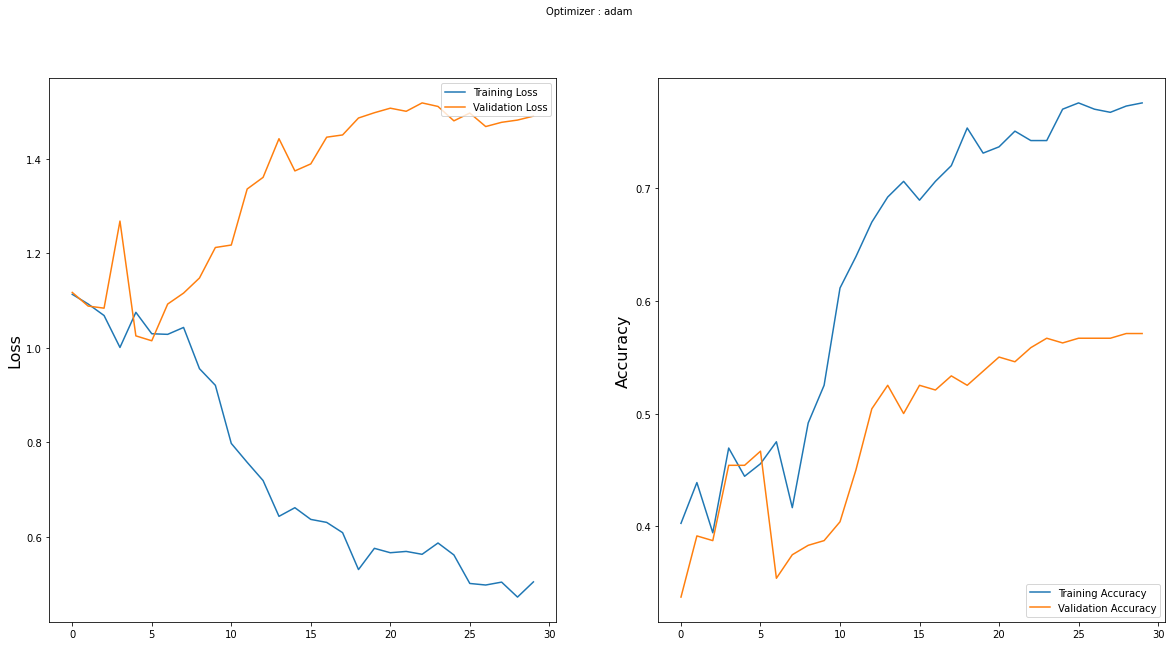

In [22]:
import matplotlib.pyplot as plt

x=hist4
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(x.history['loss'], label='Training Loss')
plt.plot(x.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(x.history['accuracy'], label='Training Accuracy')
plt.plot(x.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

# InceptionV3

In [23]:
# create the base pre-trained model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
base_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x2 = base_model.output
x2 = GlobalAveragePooling2D()(x2)

predictions = Dense(3, activation='softmax')(x2)

# this is the model we will train
model6 = Model(inputs=base_model.input, outputs=predictions)
model6.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=["accuracy",f1_m,precision_m, recall_m])
model6.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, None, None, 3 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d_2[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
____________________________________________________________________________________________

In [24]:
hist6 = model6.fit(train_set, validation_data=test_set, epochs=30, steps_per_epoch=len(train_set), validation_steps=len(test_set),callbacks=[learning_rate_reduction, early_stop])

Epoch 1/30
180/180 [==============================] - 18s 72ms/step - loss: 1.6583 - accuracy: 0.3694 - f1_m: 0.3398 - precision_m: 0.3694 - recall_m: 0.3250 - val_loss: 434.1194 - val_accuracy: 0.4167 - val_f1_m: 0.4167 - val_precision_m: 0.4167 - val_recall_m: 0.4167
Epoch 2/30
180/180 [==============================] - 12s 69ms/step - loss: 1.4429 - accuracy: 0.3750 - f1_m: 0.3009 - precision_m: 0.3417 - recall_m: 0.2806 - val_loss: 23.2202 - val_accuracy: 0.3625 - val_f1_m: 0.3278 - val_precision_m: 0.3583 - val_recall_m: 0.3125
Epoch 3/30
180/180 [==============================] - 12s 69ms/step - loss: 1.3609 - accuracy: 0.3750 - f1_m: 0.2704 - precision_m: 0.3389 - recall_m: 0.2361 - val_loss: 67.3566 - val_accuracy: 0.5042 - val_f1_m: 0.4944 - val_precision_m: 0.5167 - val_recall_m: 0.4833
Epoch 4/30
180/180 [==============================] - 12s 69ms/step - loss: 1.2902 - accuracy: 0.3528 - f1_m: 0.2528 - precision_m: 0.2917 - recall_m: 0.2333 - val_loss: 16320.4443 - val_accur

In [25]:
dl_acc = hist6.history["val_accuracy"][12]
dl_prec = hist6.history["val_precision_m"][12]
dl_rec = hist6.history["val_recall_m"][12]
dl_f1 = hist6.history["val_f1_m"][12]

storeResults('InceptionV3',dl_acc,dl_prec,dl_rec,dl_f1)

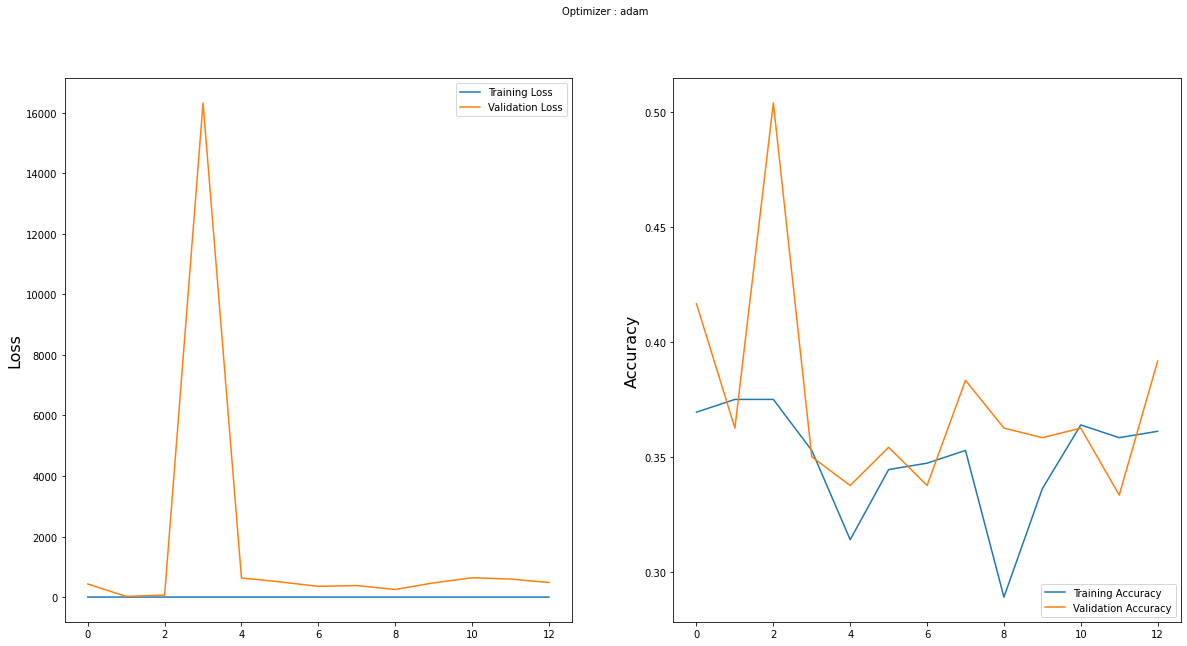

In [26]:
import matplotlib.pyplot as plt

x=hist6
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(x.history['loss'], label='Training Loss')
plt.plot(x.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(x.history['accuracy'], label='Training Accuracy')
plt.plot(x.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

# DenseNet201

In [27]:
from tensorflow.keras.applications import DenseNet201

In [28]:
des201=DenseNet201(input_shape = IMAGE_SIZE + [3], weights='imagenet', include_top=False)

x1= Flatten()(des201.output)
prediction1 = Dense(3, activation='softmax')(x1)
model9 = Model(inputs = des201.inputs, outputs = prediction1)
model9.summary()
model9.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=["accuracy",f1_m,precision_m, recall_m])

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 134, 134, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 64, 64, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [29]:
hist9 = model9.fit(train_set, validation_data=test_set, epochs=30, steps_per_epoch=len(train_set), validation_steps=len(test_set),callbacks=[learning_rate_reduction, early_stop])

Epoch 1/30
180/180 [==============================] - 39s 144ms/step - loss: 7.9794 - accuracy: 0.4278 - f1_m: 0.4241 - precision_m: 0.4278 - recall_m: 0.4222 - val_loss: 59.9220 - val_accuracy: 0.4792 - val_f1_m: 0.4792 - val_precision_m: 0.4792 - val_recall_m: 0.4792
Epoch 2/30
180/180 [==============================] - 24s 133ms/step - loss: 2.6901 - accuracy: 0.5278 - f1_m: 0.5296 - precision_m: 0.5389 - recall_m: 0.5250 - val_loss: 67.6037 - val_accuracy: 0.5750 - val_f1_m: 0.5750 - val_precision_m: 0.5833 - val_recall_m: 0.5708
Epoch 3/30
180/180 [==============================] - 25s 136ms/step - loss: 3.5929 - accuracy: 0.4611 - f1_m: 0.4528 - precision_m: 0.4583 - recall_m: 0.4500 - val_loss: 30.6834 - val_accuracy: 0.4917 - val_f1_m: 0.4931 - val_precision_m: 0.4958 - val_recall_m: 0.4917
Epoch 4/30
180/180 [==============================] - 24s 133ms/step - loss: 2.0903 - accuracy: 0.5389 - f1_m: 0.5306 - precision_m: 0.5417 - recall_m: 0.5250 - val_loss: 8.5877 - val_accura

In [34]:
dl_acc = hist9.history["val_accuracy"][24]
dl_prec = hist9.history["val_precision_m"][24]
dl_rec = hist9.history["val_recall_m"][24]
dl_f1 = hist9.history["val_f1_m"][24]

storeResults('DenseNet201',dl_acc,dl_prec,dl_rec,dl_f1)

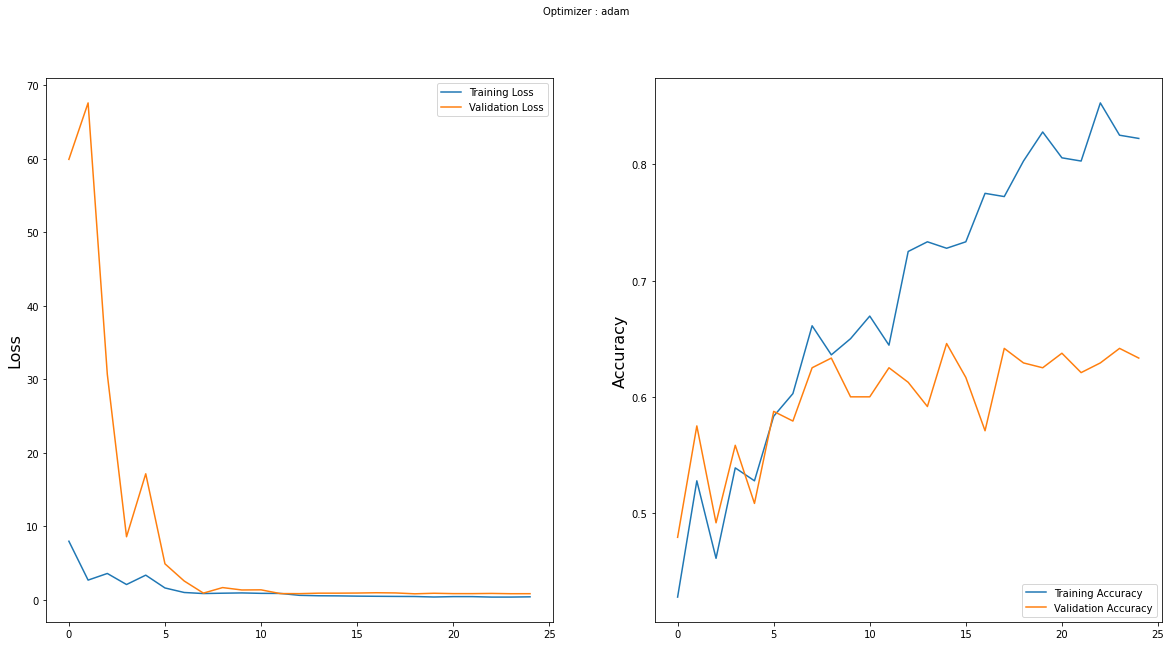

In [35]:
import matplotlib.pyplot as plt

x=hist9
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(x.history['loss'], label='Training Loss')
plt.plot(x.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(x.history['accuracy'], label='Training Accuracy')
plt.plot(x.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

# Xception

In [30]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.optimizers import Adam

In [31]:
# Defining the pretrained base model
base = Xception(include_top=False, weights='imagenet', input_shape=(128,128,3))
x = base.output
x = GlobalAveragePooling2D()(x)
# Defining the head of the model where the prediction is conducted
head = Dense(3, activation='softmax')(x)
# Combining base and head 
model11 = Model(inputs=base.input, outputs=head)

model11.compile(optimizer='sgd', 
              loss = 'categorical_crossentropy', 
              metrics=["accuracy",f1_m,precision_m, recall_m])

In [32]:
model11.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 63, 63, 32)   864         input_4[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 63, 63, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 63, 63, 32)   0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [37]:
hist11 = model11.fit(train_set, validation_data=test_set, epochs=30, steps_per_epoch=len(train_set), validation_steps=len(test_set))

Epoch 1/30
120/120 [==============================] - 6s 54ms/step - loss: 0.0026 - accuracy: 1.0000 - f1_m: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - val_loss: 0.0202 - val_accuracy: 0.9958 - val_f1_m: 0.9958 - val_precision_m: 0.9958 - val_recall_m: 0.9958
Epoch 2/30
120/120 [==============================] - 7s 55ms/step - loss: 0.0026 - accuracy: 1.0000 - f1_m: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - val_loss: 0.0184 - val_accuracy: 0.9958 - val_f1_m: 0.9958 - val_precision_m: 0.9958 - val_recall_m: 0.9958
Epoch 3/30
120/120 [==============================] - 7s 55ms/step - loss: 0.0238 - accuracy: 0.9917 - f1_m: 0.9889 - precision_m: 0.9917 - recall_m: 0.9875 - val_loss: 0.0277 - val_accuracy: 0.9958 - val_f1_m: 0.9958 - val_precision_m: 0.9958 - val_recall_m: 0.9958
Epoch 4/30
120/120 [==============================] - 7s 55ms/step - loss: 0.0047 - accuracy: 1.0000 - f1_m: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - val_loss: 0.0280 - val_accuracy: 0.9958 

In [38]:
dl_acc = hist11.history["val_accuracy"][29]
dl_prec = hist11.history["val_precision_m"][29]
dl_rec = hist11.history["val_recall_m"][29]
dl_f1 = hist11.history["val_f1_m"][29]

storeResults('Xception',dl_acc,dl_prec,dl_rec,dl_f1)

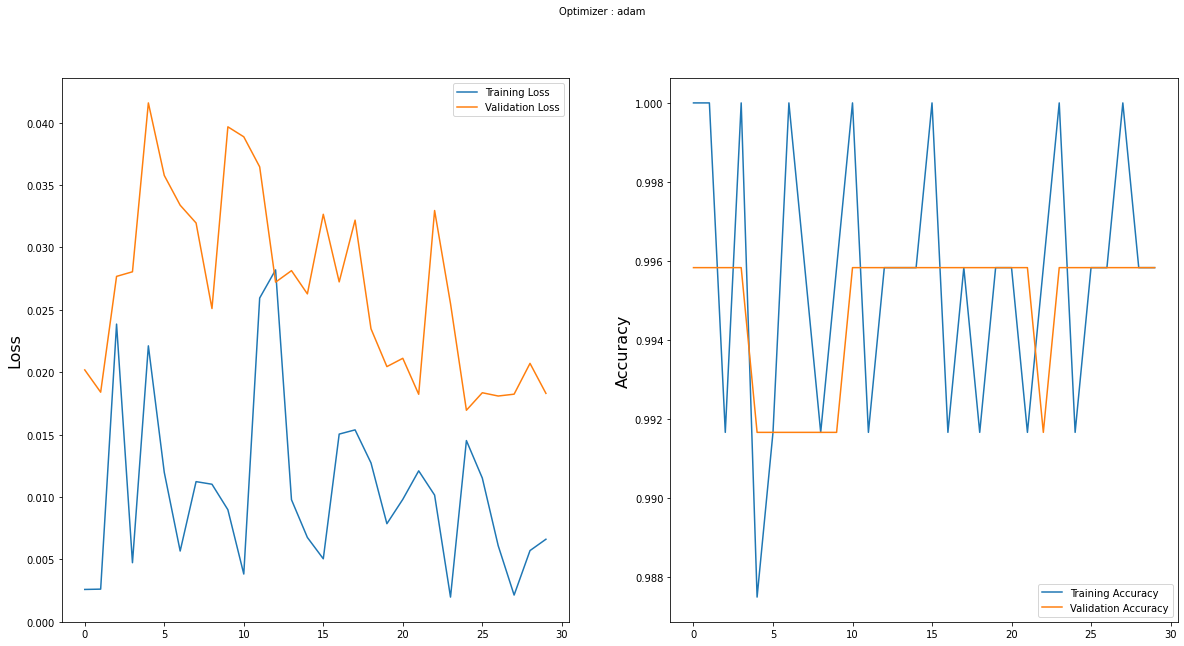

In [39]:
import matplotlib.pyplot as plt

x=hist11
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(x.history['loss'], label='Training Loss')
plt.plot(x.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(x.history['accuracy'], label='Training Accuracy')
plt.plot(x.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

# Comparison

In [40]:
#creating dataframe
import pandas as pd
result = pd.DataFrame({ 'ML Model' : ML_Model,
                        'Accuracy' : accuracy,
                       'Precision': precision,
                       'Recall'   : recall, 
                       'F1_score' : f1score                        
                      })

In [41]:
result

,ML Model,Accuracy,Precision,Recall,F1_score
0,ResNet50,0.654,0.650,0.629,0.636
1,CNN,0.571,0.575,0.479,0.511
2,InceptionV3,0.392,0.229,0.129,0.162
3,DenseNet201,0.633,0.633,0.621,0.625
4,Xception,0.996,0.996,0.996,0.996


# Model Dumping

In [42]:
model11.save('model.h5')

# Graph

In [43]:
classifier = ML_Model
y_pos = np.arange(len(classifier))

# Accuracy

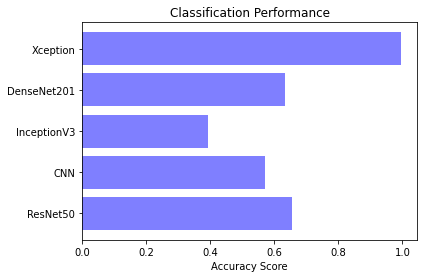

In [44]:
import matplotlib.pyplot as plt2
plt2.barh(y_pos, accuracy, align='center', alpha=0.5,color='blue')
plt2.yticks(y_pos, classifier)
plt2.xlabel('Accuracy Score')
plt2.title('Classification Performance')
plt2.show()

# Precision

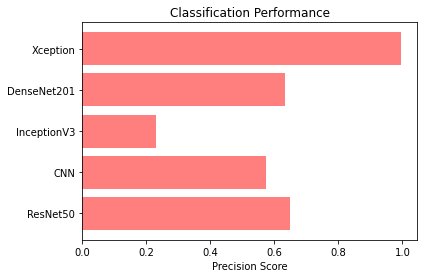

In [45]:
plt2.barh(y_pos, precision, align='center', alpha=0.5,color='red')
plt2.yticks(y_pos, classifier)
plt2.xlabel('Precision Score')
plt2.title('Classification Performance')
plt2.show()

# Recall

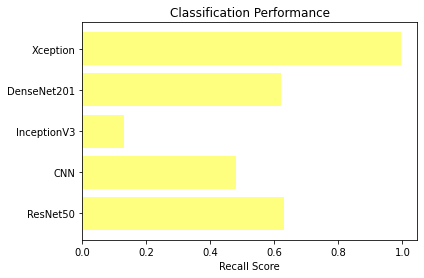

In [46]:
plt2.barh(y_pos, recall, align='center', alpha=0.5,color='yellow')
plt2.yticks(y_pos, classifier)
plt2.xlabel('Recall Score')
plt2.title('Classification Performance')
plt2.show()

# F1 Score

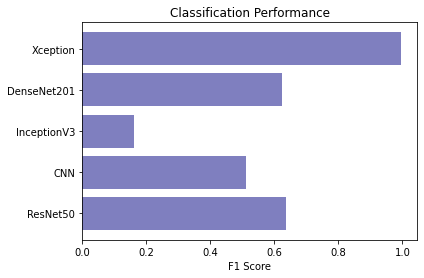

In [47]:
plt2.barh(y_pos, f1score, align='center', alpha=0.5,color='navy')
plt2.yticks(y_pos, classifier)
plt2.xlabel('F1 Score')
plt2.title('Classification Performance')
plt2.show()